# Laurentia paleogeographic reconstructions generation

This Jupyter notebook develops paleogeographic reconstructions for Laurentia using the ```pygplates``` module (it therefore needs to be run with a Python 2.7 kernel). It is associated with the manuscript:

**The Precambrian paleogeography of Laurentia** written by Nicholas L. Swanson-Hysell for a book entitled *Ancient Supercontinents and the Paleogeography of the Earth*

The paleogeographic reconstructions use the model of Whitmeyer and Karlstrom (2007) with additions for Greenland based on St-Onge et al. 2009. The following PLATE_ID values are used for the different elements. Some of these 4-digit numbers follow the model of Eglington and Evans. The Eglington and Evans model had many more tectonic blocks than that of Whitmeyer and Karlstrom such that these assignments correspond to one of the numerous blocks that make up a given block.

## Terrane plate IDs

| Tectonic Block | Plate ID | Plate ID note |
|------|-----|-----|
| Churchill Province | 10496 | corresponds to Churchill (SE) in EE |
| Hearne Province | 10015 | corresponds to Hearne South in EE |
| Greenland_Aasiaat | 10028 | corresponds to Aasiaat in EE |
| Greenland_Inglefield | 10568 | corresponds to Inglefield in EE |
| Greenland_Ketilidian | 10018 | corresponds to Ketilidian in EE |
| Greenland_NorthAtlantic | 10032 | corresponds to North Atlantic in EE |
| Greenland_Rae | 10036 | corresponds to Rae (Greenland) in EE |
| Grouse Creek Block | 19049 |  No equivelant block in EE (grouped with Wyoming) |
| Marshfield Terrane | 19000 | No equivelant block in EE |
| Medicine Hat Block | 10551 | corresponds to Medicine Hat in EE|
| MetaIncognita Block | 10545 | Not given this name in WK07, but has differential motion relative to Rae; corresponds to MetaIncognita Block in EE |
| Nain | 10029 | corresponds to Nain in EE (mainland Canada) |
| Mojavia | 10052 | corresponds to Mojave in EE |
| Nova | 10549 | Cordillera Archean Block in WK07; corresponds to Paleoproteroic Nova Block in EE |
| Rae Province | 10640 | corresponds to Rae (SW) in EE |
| Sask craton | 10039 | correspond to Sask in EE |
| Scotland | 10258 | not a block in the WK07 model, but assigned to pole list; corresponds to N Highlands in EE
| Slave Province | 10041 | corresponds to Slave W in EE |
| Superior (east) | 10043 | corresponds to Superior (Abitibi) in EE |
| Superior (west) | 10023 | corresponds to Superior (Minnesota River Valley) in EE |
| Svalbard | 10296 | corresponds to Svalbard E in EE |
| Wyoming Province | 10049 | corresponds to Wyoming in EE |

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygplates

## Make GMPL files of poles

In [19]:
def make_GPML(pmag_data,output_file_name):
    vgps = []
    for n in pmag_data.index:
        # The pole position and the average sample site position.
        pole_position = pygplates.PointOnSphere(pmag_data.PLAT[n], pmag_data.PLONG[n])
        average_sample_site_position = pygplates.PointOnSphere(pmag_data.SLAT[n], pmag_data.SLONG[n])

        # Create the virtual geomagnetic pole feature.
        virtual_geomagnetic_pole_feature = pygplates.Feature.create_reconstructable_feature(
            pygplates.FeatureType.gpml_virtual_geomagnetic_pole,pole_position,
            name=str(pmag_data.ROCKNAME[n]),reconstruction_plate_id=int(pmag_data.Plate_ID[n]))
        
        #, reconstruction_plate_id=str(pmag_data.Plate_ID[n]))

        # Set the average sample site position.
        # We need to specify its property name otherwise it defaults to the pole position and overwrites it.
        virtual_geomagnetic_pole_feature.set_geometry(
            average_sample_site_position,
            pygplates.PropertyName.gpml_average_sample_site_position) 
        
        # Set the pole position uncertainty and the average age.
        virtual_geomagnetic_pole_feature.set_double(
            pygplates.PropertyName.gpml_pole_a95,
            float(pmag_data.A95[n]))
        virtual_geomagnetic_pole_feature.set_double(
            pygplates.PropertyName.gpml_average_age,
            pmag_data['nominal age'][n])
        vgps.append(virtual_geomagnetic_pole_feature)
        
    output_features = pygplates.FeatureCollection(vgps)

    # Note that the output format could be shp, gmt, gpml or gpmlz - the extension controls the format
    output_features.write(output_file_name)

In [20]:
Leirubakki_poles = pd.read_csv('../Data/Leirubakki_poles_w_PlateID.csv')
Leirubakki_poles.dropna(subset = ["Plate_ID"], inplace=True)
make_GPML(Leirubakki_poles,'../Data/Laurentia_poles.gpml')

In [21]:
running_mean = pd.read_csv('../Data/Laurentia_running_mean.csv')
make_GPML(running_mean,'../Data/Laurentia_running_mean.gpml')

## Make Laurentia reconstructions with a simple Laurentia rotation model

In [5]:
rotation_model = pygplates.FeatureCollection('../Models/simple_Laurentia_model.rot')

anchor_plate = 0
Laurentia_pre_430 = '../Data/Whitmeyer2007_GIS/Laurentia.shp'

pygplates.reconstruct(Laurentia_pre_430, rotation_model, '../Reconstructions/Proterozoic_Laurentia_simple/0Ma_Laurentia_pre_430.shp', 0, anchor_plate)
#for reconstruction_time in [1740,1440,1140,740]:
for reconstruction_time in [2220,2120,1980,1880,1800,1750,1600,1450,1300,1150,1000,850,700,550,0]:
    export_filename = '../Reconstructions/Proterozoic_Laurentia_simple/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_pre_430, rotation_model, export_filename, reconstruction_time, anchor_plate)

Calculate and export the Euler poles for Laurentia associated with the reconstruction times and export to .csv

In [6]:
input_rotation_filename = '../Models/simple_Laurentia_model.rot'
times = [1750,1600,1450,1300,1150,1000,850,700,550]
plate_id = 1000
empty_series = pd.Series(np.zeros(len(times)))
rotations = pd.DataFrame(columns = ['time', 'pole_lat', 'pole_lon', 'pole_angle'])
rotations['time'] = empty_series
rotations['pole_lat'] = empty_series
rotations['pole_lon'] = empty_series
rotations['pole_angle'] = empty_series

rotation_model_object = pygplates.RotationModel(input_rotation_filename)

for n in range(0,len(times)):
    finite_rotation = rotation_model_object.get_rotation(times[n],plate_id,0,0)
    pole_lat,pole_lon,pole_angle = finite_rotation.get_lat_lon_euler_pole_and_angle_degrees()
    rotations['time'][n] = times[n]
    rotations['pole_lat'][n] = pole_lat
    rotations['pole_lon'][n] = pole_lon
    rotations['pole_angle'][n] = pole_angle

rotations.to_csv('../Reconstructions/euler_rotations_Laurentia.csv')

In [7]:
def make_euler_file(plate_id,times,input_rotation_filename):
    
    empty_series = pd.Series(np.zeros(len(times)))
    rotations = pd.DataFrame(columns = ['time', 'pole_lat', 'pole_lon', 'pole_angle'])
    rotations['time'] = empty_series
    rotations['pole_lat'] = empty_series
    rotations['pole_lon'] = empty_series
    rotations['pole_angle'] = empty_series

    rotation_model_object = pygplates.RotationModel(input_rotation_filename)

    for n in range(0,len(times)):
        finite_rotation = rotation_model_object.get_rotation(times[n],plate_id,0,0)
        pole_lat,pole_lon,pole_angle = finite_rotation.get_lat_lon_euler_pole_and_angle_degrees()
        rotations['time'][n] = times[n]
        rotations['pole_lat'][n] = pole_lat
        rotations['pole_lon'][n] = pole_lon
        rotations['pole_angle'][n] = pole_angle

    rotations.to_csv('../Reconstructions/euler_rotations_{0}.csv'.format(plate_id))
    
make_euler_file(10043,[2220,2120,1980,1880,1800,0],'../Models/simple_Laurentia_model.rot')
make_euler_file(10023,[2220,2120,1980,1880,1800,0],'../Models/simple_Laurentia_model.rot')
make_euler_file(10041,[2220,2120,1980,1880,1800,0],'../Models/simple_Laurentia_model.rot')
make_euler_file(10640,[2220,2120,1980,1880,1800,0],'../Models/simple_Laurentia_model.rot')
make_euler_file(1000,[2220,2120,1980,1880,1800,0],'../Models/simple_Laurentia_model.rot')

In [8]:
Laurentia_poles = pygplates.FeatureCollection('../Data/Laurentia_poles.gpml')
pygplates.reconstruct(Laurentia_poles, rotation_model, '../Reconstructions/Laurentia_poles_1750.shp', 1750, anchor_plate)

Apply to simple CEED6 Laurentia outline:

In [9]:
rotation_model = pygplates.FeatureCollection('../Models/simple_Laurentia_model.rot')

anchor_plate = 0
Laurentia_pre_430 = '../Models/CEED6_poly_430_530_noGreenland_1000/CEED6_POLY.shp'

pygplates.reconstruct(Laurentia_pre_430, rotation_model, '../Reconstructions/Proterozoic_Laurentia_simple/0Ma_Laurentia_pre_430.shp', 0, anchor_plate)
# for reconstruction_time in np.arange(530,1800,10):
for reconstruction_time in np.arange(1000,1100,10):
    export_filename = '../Reconstructions/Proterozoic_Laurentia_simple_outline/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_pre_430, rotation_model, export_filename, reconstruction_time, anchor_plate)

## Make Superior and Slave Province reconstructions prior to Laurentia assembly 

In [10]:
rotation_model = pygplates.FeatureCollection('../Models/simple_Laurentia_model.rot')

anchor_plate = 0
Laurentia_pre_430 = '../Data/Whitmeyer2007_GIS/Laurentia.shp'

pygplates.reconstruct(Laurentia_pre_430, rotation_model, '../Reconstructions/Proterozoic_Laurentia_simple/0Ma_Laurentia_pre_430.shp', 0, anchor_plate)
#for reconstruction_time in [1740,1440,1140,740]:
for reconstruction_time in [1750,1600,1450,1300,1150,1000,850,700,550]:
    export_filename = '../Reconstructions/Proterozoic_Laurentia_simple/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_pre_430, rotation_model, export_filename, reconstruction_time, anchor_plate)

# Calculate centroid paths for Laurentia using different models

This noteboook contains code associated the manuscript chapter on Laurentia written by N. Swanson-Hysell for the book *“Ancient Supercontinents and the Paleogeography of the Earth.”* It calculates and exports motion paths implied for Laurentia by different paleogeographic models.



In [22]:
import numpy as np
import pygplates
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
duluth_lat = 46.8
duluth_lon = 267.9

## Define a function that calculates a motion path of a point

We want the motion path relative to the present. As a result, we need to set the digitisation_time and reconstruction_time to be 0. The function below calculates the motion path from the max_age until the present and then returns the motion path between the max_age and the provided min_age.

In [24]:
def motion_path_calc(point_lat,point_lon,min_age,max_age,rotation_file_path,moving_plate_id,relative_plate_id):
    
    rotation_model = pygplates.RotationModel(rotation_file_path)
    
    SeedPoint = (point_lat,point_lon)
    MovingPlate = moving_plate_id
    RelativePlate = relative_plate_id
    times = np.arange(0,max_age,2)
    times_output = np.arange(min_age,max_age,2)
    
    # Create a motion path feature
    digitisation_time = 0
    seed_points_at_digitisation_time = pygplates.MultiPointOnSphere([SeedPoint]) 
    motion_path_feature = pygplates.Feature.create_motion_path(
            seed_points_at_digitisation_time,
            times,
            valid_time=(max_age, 0),
            relative_plate=RelativePlate,
            reconstruction_plate_id = MovingPlate)
    
    # Create the shape of the motion path
    reconstruction_time = 0
    reconstructed_motion_paths = []
    pygplates.reconstruct(
            motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time,
            reconstruct_type=pygplates.ReconstructType.motion_path)

    # get the reconstructed coordinates into numpy arrays
    for reconstructed_motion_path in reconstructed_motion_paths:
        trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()
        
    return np.flipud(times_output), trail[0:len(times_output)]

## Torsvik and Cocks, 2017

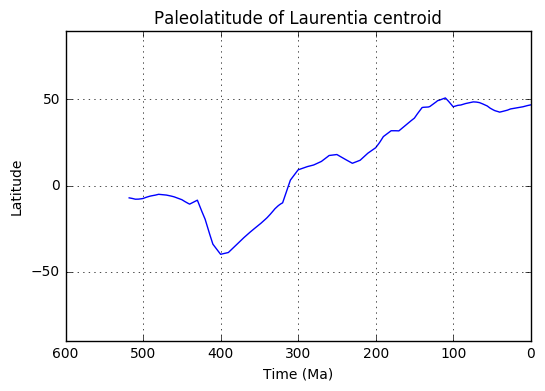

In [25]:
rotation_file_path = '../models/TC2017.rot'
TC_2017_times, TC_2017_trail = motion_path_calc(duluth_lat,duluth_lon,0,520,rotation_file_path,101,1)

plt.plot(TC_2017_times,TC_2017_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

TC_2017_centroid_plat = pd.DataFrame(data=[TC_2017_times.tolist(),TC_2017_trail[:,0].tolist()]).transpose()
TC_2017_centroid_plat.to_csv('../models/motion_paths/Torsvik_2017_duluth_reconstruct.csv')

## Swanson-Hysell and Macdonald, 2017

This model is a modification of the Torsvik and Cocks (2017) model and utilizes data from allochthonous terranes as constraints in the Ordovician.

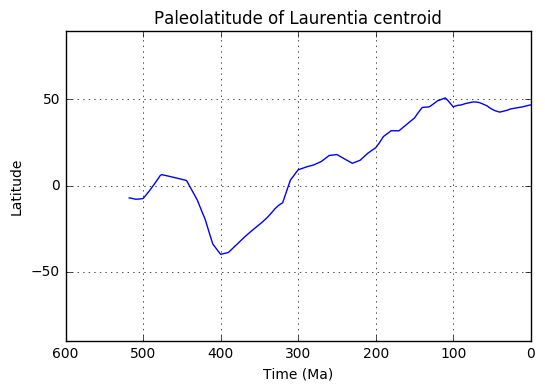

In [26]:
rotation_file_path = '../models/TC2017_SHM2017_modified.rot'
SH_2017_times, SH_2017_trail = motion_path_calc(duluth_lat,duluth_lon,0,520,rotation_file_path,101,1)

plt.plot(SH_2017_times,SH_2017_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

SH_2017_centroid_plat = pd.DataFrame(data=[SH_2017_times.tolist(),SH_2017_trail[:,0].tolist()]).transpose()
SH_2017_centroid_plat.to_csv('../models/motion_paths/SH_2017_duluth_reconstruct.csv')

## Wright et al., 2013

This model is the default model being used in Macrostrat. It seeks to cover the entiriety of the Phanerozoic. It has many fewer tectonic elements than Torsvik and Cocks (2017).

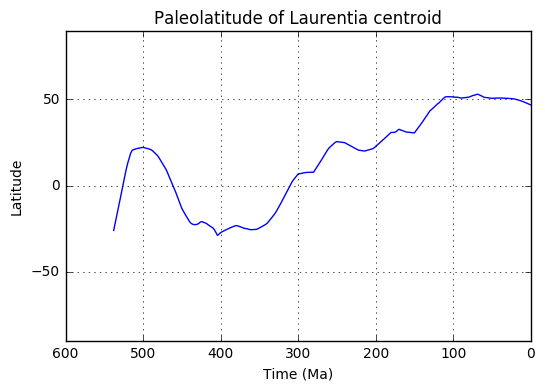

In [27]:
rotation_file_path = '../models/Wright2013.rot'
W_2013_times, W_2013_trail = motion_path_calc(duluth_lat,duluth_lon,0,539,rotation_file_path,101,0)

plt.plot(W_2013_times,W_2013_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

W_2013_centroid_plat = pd.DataFrame(data=[W_2013_times.tolist(),W_2013_trail[:,0].tolist()]).transpose()
W_2013_centroid_plat.to_csv('../models/motion_paths/W_2013_duluth_reconstruct.csv')

## Li, Evans and Halverson 2013

This rotation file was not published with the 2013 study, but was provided by Dave Evans in November 2019. Laurentia is plate 199 and its position is given from 1100 Ma to Pangea assembly 

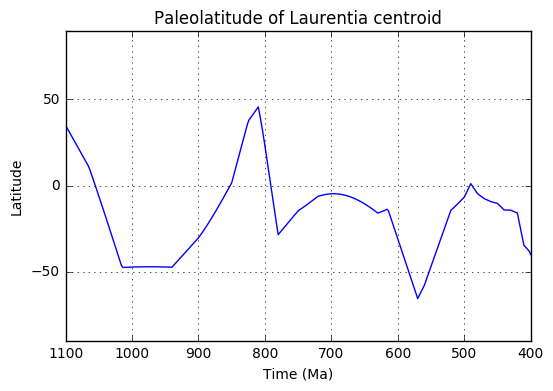

In [28]:
rotation_file_path = '../models/LiEvansHalverson2013.rot'

LEH_2013_times, LEH_2013_trail = motion_path_calc(duluth_lat,duluth_lon,400,1100,rotation_file_path,199,0)

plt.plot(LEH_2013_times,LEH_2013_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

LEH_2013_centroid_plat = pd.DataFrame(data=[LEH_2013_times.tolist(),LEH_2013_trail[:,0].tolist()]).transpose()
LEH_2013_centroid_plat.to_csv('../models/motion_paths/LEH_2013_duluth_reconstruct.csv')

## Merdith et al., 2017

The model starts in earnest at 1000 Ma. However, Laurentia's rotations in the .rot file go back to 1100 Ma and continue to 410 Ma.

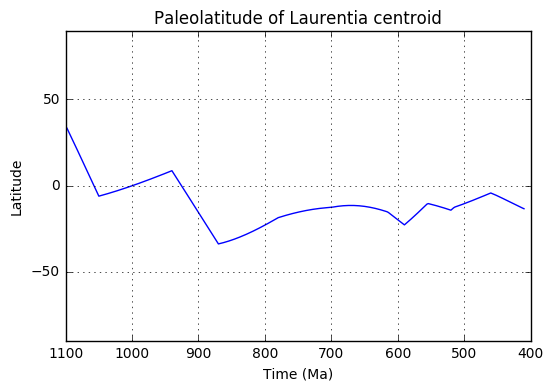

In [29]:
rotation_file_path = '../models/Merdith2017.rot'

M_2017_times, M_2017_trail = motion_path_calc(duluth_lat,duluth_lon,410,1100,rotation_file_path,1001,0)

plt.plot(M_2017_times,M_2017_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

M_2017_centroid_plat = pd.DataFrame(data=[M_2017_times.tolist(),M_2017_trail[:,0].tolist()]).transpose()
M_2017_centroid_plat.to_csv('../models/motion_paths/M_2017_duluth_reconstruct.csv')

## Minimal Laurentia model

This model doesn't reconstruct Laurentia based on the poles from assumed correlations (such as Baltica) and relies on Laurentia poles along with interpolation.

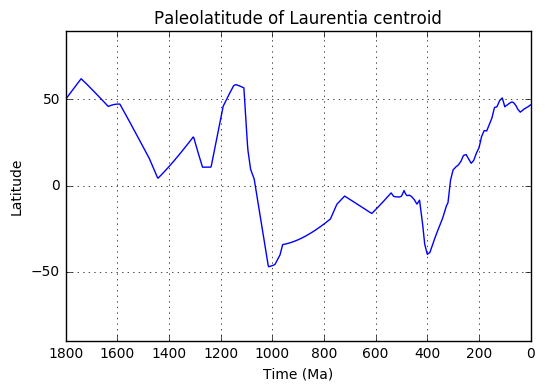

In [68]:
rotation_file_path = '../models/simple_Laurentia_model.rot'

SH_prot_times, SH_prot_trail = motion_path_calc(duluth_lat,duluth_lon,0,1800,rotation_file_path,1000,1)

plt.plot(SH_prot_times,SH_prot_trail[:,0])
plt.title('Paleolatitude of Laurentia centroid')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.ylim(-90,90)
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()

SH_prot_centroid_plat = pd.DataFrame(data=[SH_prot_times.tolist(),SH_prot_trail[:,0].tolist()]).transpose()
SH_prot_centroid_plat.to_csv('../models/motion_paths/SH_prot_duluth_simple_reconstruct.csv')

In [69]:
evaporites = pd.read_csv('../data/evaporites.csv')
evaporites

,Formation,lat,lon,age,age_lower,age_upper
0,lower Belt Supergroup,49.0,-114,1470,1500,1466
1,upper Belt Supergroup,49.0,-114,1454,1463,1443
2,Iqqittuq,72.3,-81,1047,1060,1030
3,Ten Stone,64.5,-130,850,900,811
4,Minto Inlet,72.0,-113,850,900,811
5,Redstone River,64.5,-130,745,780,727
6,Kilian,72.0,-113,745,780,727
7,Canadian Maritime,46.0,298,340,340,340
8,Sverdrup,79.0,264,315,315,315
9,Midcontinental USA,41.0,257,270,270,270


In [120]:
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

rotation_file_path = '../models/simple_Laurentia_model.rot'

plt.figure(figsize=(8,4.5))

for n in range(0,len(evaporites)):

    evaporite_lat = evaporites.lat[n]
    evaporite_lon = evaporites.lon[n]

    age = evaporites.age[n]
    age_lower = evaporites.age_lower[n]
    age_upper = evaporites.age_upper[n]

    evaporite_times, evaporite_path = motion_path_calc(evaporite_lat,evaporite_lon,age_upper,age_lower,rotation_file_path,1000,1)

    plt.plot(evaporite_times,evaporite_path[:,0],color='brown')
    
    evaporite_times, evaporite_path = motion_path_calc(evaporite_lat,evaporite_lon,age-2,age,rotation_file_path,1000,1)
    
    plt.scatter(evaporite_times[0],evaporite_path[:,0][0],color='brown')

rotation_file_path = '../models/LiEvansHalverson2013.rot'

for n in range(2,7):


    evaporite_lat = evaporites.lat[n]
    evaporite_lon = evaporites.lon[n]

    age = evaporites.age[n]
    age_lower = evaporites.age_lower[n]
    age_upper = evaporites.age_upper[n]

    evaporite_times, evaporite_path = motion_path_calc(evaporite_lat,evaporite_lon,age_upper,age_lower,rotation_file_path,199,0)

    plt.plot(evaporite_times,evaporite_path[:,0],color='green')
    
    evaporite_times, evaporite_path = motion_path_calc(evaporite_lat,evaporite_lon,age-2,age,rotation_file_path,199,0)
    
    plt.scatter(evaporite_times[0],evaporite_path[:,0][0],color='green')   
    
plt.text(evaporites.age[0],80,'1,2',horizontalalignment='left')
plt.text(evaporites.age[2],80,'3',horizontalalignment='center')
plt.text(evaporites.age[3],80,'4,5',horizontalalignment='center')
plt.text(evaporites.age[5],80,'6,7',horizontalalignment='center')
plt.text(evaporites.age[7],80,'8,9,10',horizontalalignment='left')
    
south_arid = patches.Rectangle((1800,-35),
                 -1800,
                 25,
                 edgecolor='none',
                 facecolor = 'khaki',zorder=-1)

plt.gca().add_patch(south_arid)

north_arid = patches.Rectangle((1800,10),
                 -1800,
                 25,
                 edgecolor='none',
                 facecolor = 'khaki',zorder=-1)

plt.plot(SH_prot_times,SH_prot_trail[:,0],color='grey',zorder=1)

plt.gca().add_patch(north_arid)

    
#plt.title('Paleolatitude of Laurentia evaporites')
plt.xlabel('Time (Ma)')
plt.ylabel('Paleolatitude ($\circ$)')
plt.ylim(-90,90)
plt.xlim(0,1799)
plt.gca().set_yticks([-90.,  -60.,  -30.,
                                    0.,   30.,   60., 90.])
plt.gca().grid()
plt.gca().invert_xaxis()


legend_elements = [Line2D([0], [0], color='grey', lw=1, label='Duluth latitude (simple Laurentia model)'),
                   Line2D([0], [0], marker='o', color='white', label='evaporites (simple Laurentia model)',
                          markerfacecolor='brown', markersize=6),
                   Line2D([0], [0], marker='o', color='white', label='evaporites (Li, Evans, and Halverson 2013)',
                          markerfacecolor='green', markersize=6),
                   Patch(facecolor='khaki', edgecolor='none',
                         label='arid latitudes')]

plt.gca().legend(handles=legend_elements, prop={'size': 9},loc=4)

plt.savefig('../Figures/Laurentia_evaporite_paleolatitude.pdf')
plt.show()

NameError: name 'mlines' is not defined

array([[  28.70087457,  107.4436464 ],
       [  28.20646295,  107.28801798],
       [  27.71116221,  107.1367932 ],
       [  27.21500105,  106.98989706],
       [  26.71800745,  106.84725689],
       [  26.22020874,  106.70880229],
       [  25.72163154,  106.57446509],
       [  25.22230188,  106.44417927],
       [  24.72224515,  106.31788093],
       [  24.22148617,  106.19550824],
       [  23.72004919,  106.07700138],
       [  23.21795792,  105.9623025 ],
       [  22.49355947,  105.99191829],
       [  21.76914479,  106.02091085],
       [  21.04471442,  106.0492989 ],
       [  20.32026885,  106.07710035],
       [  19.59580857,  106.10433237]])

In [19]:
####ORIGINAL FUNCTION THAT INCLUDES THE PARTITION INTO PLATES TAKING A PLATE MODEL FUNCTIONALITY####

def make_GPML_w_plates(pmag_data,static_polygons_file_path,
                       rotation_model_file_path,output_file_name):
    """
    pmag_data : data frame with paleomagnetic poles. It needs to have fields
                named PLONG, PLAT, SLONG, SLAT, A95 and nominal_age
    static_polygons_file_path : string to static polygons are the 'partitioning 
        features used to assign plate IDs
    rotation_model_file_path : string to rotation model partition_into_plates 
        function requires a rotation model, since sometimes this would be 
        necessary even at present day (for example to resolve topological polygons)
    output_file_name : string for output file
    """
    vgps = []
    for n in pmag_data.index:
        # The pole position and the average sample site position.
        pole_position = pygplates.PointOnSphere(pmag_data.PLAT[n], pmag_data.PLONG[n])
        average_sample_site_position = pygplates.PointOnSphere(pmag_data.SLAT[n], pmag_data.SLONG[n])

        # Create the virtual geomagnetic pole feature.
        virtual_geomagnetic_pole_feature = pygplates.Feature.create_reconstructable_feature(
            pygplates.FeatureType.gpml_virtual_geomagnetic_pole,pole_position,name=str(pmag_data.ROCKNAME[n]))
    #reconstruction_plate_id=701

        # Set the average sample site position.
        # We need to specify its property name otherwise it defaults to the pole position and overwrites it.
        virtual_geomagnetic_pole_feature.set_geometry(
            average_sample_site_position,
            pygplates.PropertyName.gpml_average_sample_site_position)

        # Set the pole position uncertainty and the average age.
        virtual_geomagnetic_pole_feature.set_double(
            pygplates.PropertyName.gpml_pole_a95,
            float(pmag_data.A95[n]))
        virtual_geomagnetic_pole_feature.set_double(
            pygplates.PropertyName.gpml_average_age,
            pmag_data['nominal age'][n])
        vgps.append(virtual_geomagnetic_pole_feature)
        
    static_polygons = pygplates.FeatureCollection(static_polygons_file_path)
    rotation_model = pygplates.RotationModel(rotation_model_file_path)
        
    # The partition points function can then be used as before
    vgps_plates = pygplates.partition_into_plates(static_polygons,rotation_model,vgps)

    output_features = pygplates.FeatureCollection(vgps_plates)

    # Note that the output format could be shp, gmt, gpml or gpmlz - the extension controls the format
    output_features.write(output_file_name)

Using the CEED6 polygons over the Phanerozoic.

In [20]:
rotation_model = pygplates.FeatureCollection('../models/TC2017_SHM2017_modified.rot')

anchor_plate = 1
Laurentia_0_300 = '../models/CEED6_poly_0_300_noGreenland/CEED6_POLY.shp'
Laurentia_300_420 = '../models/CEED6_poly_300_420_noGreenland/CEED6_POLY.shp'
Laurentia_420_430 = '../models/CEED6_poly_420_430_noGreenland/CEED6_POLY.shp'
Laurentia_430_530 = '../models/CEED6_poly_430_530_noGreenland/CEED6_POLY.shp'

pygplates.reconstruct(Laurentia_0_300, rotation_model, '../reconstructions/TC2017_SH2017/0Ma_Laurentia_0_300.shp', 0, anchor_plate)
pygplates.reconstruct(Laurentia_300_420, rotation_model, '../reconstructions/TC2017_SH2017/0Ma_Laurentia_300_420.shp', 0, anchor_plate)
pygplates.reconstruct(Laurentia_420_430, rotation_model, '../reconstructions/TC2017_SH2017/0Ma_Laurentia_420_430.shp', 0, anchor_plate)
pygplates.reconstruct(Laurentia_430_530, rotation_model, '../reconstructions/TC2017_SH2017/0Ma_Laurentia_430_530.shp', 0, anchor_plate)

for reconstruction_time in range(0,301):
    export_filename = '../reconstructions/TC2017_SH2017/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_0_300, rotation_model, export_filename, reconstruction_time, anchor_plate)
    
for reconstruction_time in range(301,421):
    export_filename = '../reconstructions/TC2017_SH2017/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_300_420, rotation_model, export_filename, reconstruction_time, anchor_plate)
    
for reconstruction_time in range(421,431):
    export_filename = '../reconstructions/TC2017_SH2017/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_420_430, rotation_model, export_filename, reconstruction_time, anchor_plate)
    
for reconstruction_time in range(431,531):
    export_filename = '../reconstructions/TC2017_SH2017/{0}Ma_Laurentia.shp'.format(reconstruction_time)
    pygplates.reconstruct(Laurentia_430_530, rotation_model, export_filename, reconstruction_time, anchor_plate)

OpenFileForReadingError: Error opening file 'CEED6_POLY.shp' for reading